<a href="https://colab.research.google.com/github/nitinsaimajji/voice1/blob/main/weekly_code/Week_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
pip install python_speech_features


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [150]:
!git clone https://github.com/nitinsaimajji/voice1.git

fatal: destination path 'voice1' already exists and is not an empty directory.


In [151]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **A1**

In [152]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from pydub import AudioSegment
from python_speech_features import mfcc
from time import time
import IPython.display as ipd
import librosa
import librosa.display

In [153]:
df = pd.read_csv('/content/voice1/wav_check.csv')
df.head()

,filename,gender
0,male-sample-000008.wav,male
1,male-sample-000014.wav,male
2,male-sample-000019.wav,male
3,male-sample-000020.wav,male
4,male-sample-000023.wav,male


In [154]:
TRAIN_PATH = '/content/voice/cv-valid-train/'
!pip install wavefile
!pip install helpers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [155]:
max_pad_len = 174

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        if mfccs.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
            
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs


In [156]:

import os

fulldatasetpath = '/content/voice1/dataset1'

df = pd.read_csv('/content/voice1/wav_check.csv')


features = []


for index, row in df.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath)+'/',str(row["filename"]))
    
    class_label = row["gender"]
    data = extract_features(file_name)
    
    features.append([data, class_label])


featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  200  files


In [157]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

## CNN ARCHITECTURE

In [158]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2


In [159]:
from keras import regularizers

## Regularization : L2 & L1 regularization

In [160]:

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 
model.add(Dense(500,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

In [161]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [162]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 19, 86, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 9, 42, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 8, 41, 64)         8256      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 4, 20, 64)      

In [163]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
1/1 [==============================] - ETA: 0s - loss: 0.7320 - accuracy: 0.5063
Epoch 1: val_loss improved from inf to 0.73068, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.7320 - accuracy: 0.5063 - val_loss: 0.7307 - val_accuracy: 0.5250
Epoch 2/72
1/1 [==============================] - ETA: 0s - loss: 0.7311 - accuracy: 0.4938
Epoch 2: val_loss improved from 0.73068 to 0.73056, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 748ms/step - loss: 0.7311 - accuracy: 0.4938 - val_loss: 0.7306 - val_accuracy: 0.4750
Epoch 3/72
1/1 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.5063
Epoch 3: val_loss improved from 0.73056 to 0.73051, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 760ms/step - loss: 0.7299 - accuracy: 0.5063 - val_loss: 0.7305 - val_accuracy: 0.4750
Epoch 4/72
1/1 [=

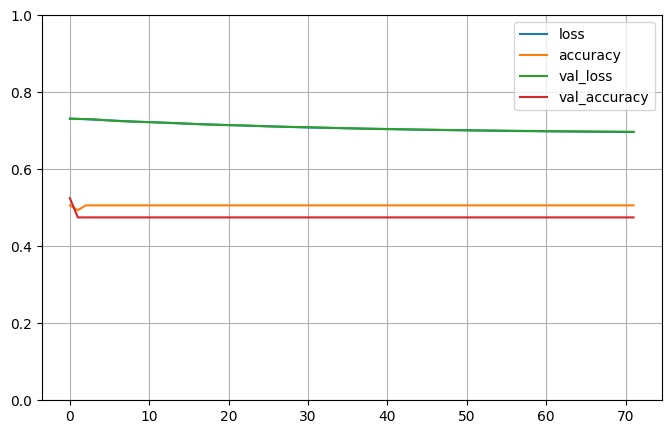

1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.
2. If the validation loss is greater than the training loss,The model is overfitting.
3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit


In [164]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print('1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.')
print('2. If the validation loss is greater than the training loss,The model is overfitting.')
print('3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit')

In [165]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100,"%")

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1]*100,"%")

Training Accuracy:  50.62500238418579 %
Testing Accuracy:  47.49999940395355 %


In [166]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

2/2 - 0s - loss: 0.6974 - accuracy: 0.4750 - 62ms/epoch - 31ms/step
Test loss: 0.697, Test accuracy: 0.475


In [167]:
from sklearn.metrics import precision_score,recall_score,f1_score

# Predict class labels on test set
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print precision score
print("Precision Score: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

2/2 [==============================] - 0s 15ms/step
Precision Score:  0.22562500000000002
Recall:  0.475
F1 Score:  0.3059322033898305


In [168]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict(prediction_feature)
    predicted_class = le.inverse_transform(np.argmax(predicted_vector, axis=-1)) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = predicted_vector
    for i in range(len(predicted_proba_vector[0])): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba_vector[0][i]*100,'.32f'),"%")

In [169]:
from pydub import AudioSegment

# set the file paths
input_file = "/content/sample-195283.mp3"
output_file = "/content/output.wav"

audio = AudioSegment.from_file(input_file, format="mp3")

audio.export(output_file, format="wav")

<_io.BufferedRandom name='/content/output.wav'>

In [170]:
filename = '/content/output.wav' 
print_prediction(filename) 

1/1 [==============================] - 0s 33ms/step
The predicted class is: female 

female 		 :  50.62226653099060058593750000000000 %
male 		 :  49.37773048877716064453125000000000 %


# Dropout

In [171]:

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 


In [172]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [173]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 19, 86, 16)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 19, 86, 16)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 9, 42, 32)        0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 9, 42, 32)       

In [174]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
1/1 [==============================] - ETA: 0s - loss: 3.0719 - accuracy: 0.4750
Epoch 1: val_loss improved from inf to 4.49365, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 3s 3s/step - loss: 3.0719 - accuracy: 0.4750 - val_loss: 4.4937 - val_accuracy: 0.5250
Epoch 2/72
1/1 [==============================] - ETA: 0s - loss: 6.1893 - accuracy: 0.4938
Epoch 2: val_loss improved from 4.49365 to 3.36590, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 845ms/step - loss: 6.1893 - accuracy: 0.4938 - val_loss: 3.3659 - val_accuracy: 0.5250
Epoch 3/72
1/1 [==============================] - ETA: 0s - loss: 4.2024 - accuracy: 0.4938
Epoch 3: val_loss improved from 3.36590 to 1.48878, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 823ms/step - loss: 4.2024 - accuracy: 0.4938 - val_loss: 1.4888 - val_accuracy: 0.4750
Epoch 4/72
1/1 [=

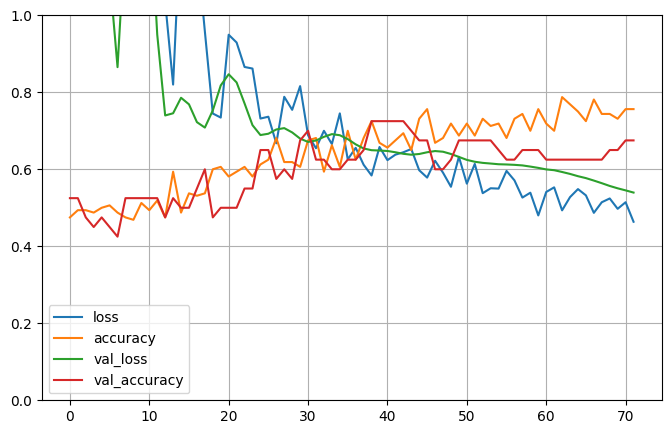

1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.
2. If the validation loss is greater than the training loss,The model is overfitting.
3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit


In [175]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print('1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.')
print('2. If the validation loss is greater than the training loss,The model is overfitting.')
print('3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit')

In [176]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100,"%")

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1]*100,"%")

Training Accuracy:  81.25 %
Testing Accuracy:  67.5000011920929 %


In [177]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

2/2 - 0s - loss: 0.5395 - accuracy: 0.6750 - 63ms/epoch - 32ms/step
Test loss: 0.540, Test accuracy: 0.675


In [178]:
from sklearn.metrics import precision_score,recall_score,f1_score

# Predict class labels on test set
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print precision score
print("Precision Score: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

2/2 [==============================] - 0s 14ms/step
Precision Score:  0.6825549450549451
Recall:  0.675
F1 Score:  0.6676660219213411


In [179]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict(prediction_feature)
    predicted_class = le.inverse_transform(np.argmax(predicted_vector, axis=-1)) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = predicted_vector
    for i in range(len(predicted_proba_vector[0])): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba_vector[0][i]*100,'.32f'),"%")

In [180]:
from pydub import AudioSegment

# set the file paths
input_file = "/content/sample-195283.mp3"
output_file = "/content/output.wav"

audio = AudioSegment.from_file(input_file, format="mp3")

audio.export(output_file, format="wav")

<_io.BufferedRandom name='/content/output.wav'>

In [181]:
filename = '/content/output.wav' 
print_prediction(filename) 

1/1 [==============================] - 0s 30ms/step
The predicted class is: female 

female 		 :  79.08149957656860351562500000000000 %
male 		 :  20.91850042343139648437500000000000 %


#  Early  Stopping

In [182]:

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 


In [183]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [184]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 19, 86, 16)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 19, 86, 16)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 9, 42, 32)        0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 9, 42, 32)       

In [185]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from keras.callbacks import EarlyStopping

earlystop= EarlyStopping(monitor='val_accuracy', patience=3)
num_epochs = 36
num_batch_size = 256

start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test),callbacks=[earlystop], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/36
1/1 [==============================] - 3s 3s/step - loss: 5.0752 - accuracy: 0.4938 - val_loss: 4.8707 - val_accuracy: 0.5250
Epoch 2/36
1/1 [==============================] - 1s 793ms/step - loss: 7.5061 - accuracy: 0.4938 - val_loss: 4.1185 - val_accuracy: 0.5250
Epoch 3/36
1/1 [==============================] - 2s 2s/step - loss: 6.0785 - accuracy: 0.5000 - val_loss: 1.7480 - val_accuracy: 0.5500
Epoch 4/36
1/1 [==============================] - 1s 1s/step - loss: 2.2044 - accuracy: 0.4875 - val_loss: 1.5197 - val_accuracy: 0.4250
Epoch 5/36
1/1 [==============================] - 1s 838ms/step - loss: 3.5066 - accuracy: 0.5000 - val_loss: 2.1378 - val_accuracy: 0.4750
Epoch 6/36
1/1 [==============================] - 1s 843ms/step - loss: 4.5291 - accuracy: 0.5125 - val_loss: 1.6735 - val_accuracy: 0.4500
Training completed in time:  0:00:08.271488


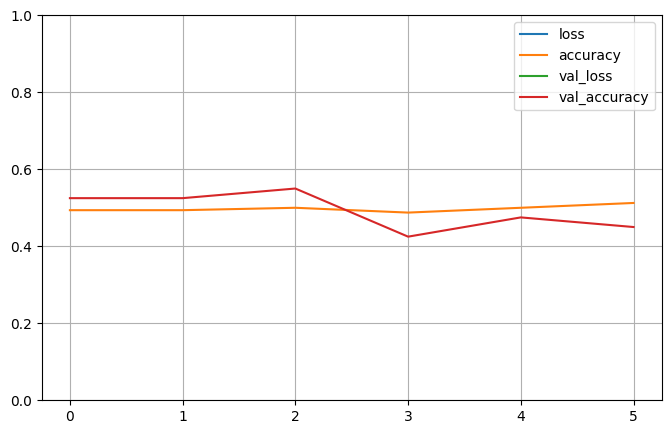

1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.
2. If the validation loss is greater than the training loss,The model is overfitting.
3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit


In [186]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print('1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.')
print('2. If the validation loss is greater than the training loss,The model is overfitting.')
print('3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit')

In [187]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100,"%")

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1]*100,"%")

Training Accuracy:  50.0 %
Testing Accuracy:  44.999998807907104 %


In [188]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

2/2 - 0s - loss: 1.6735 - accuracy: 0.4500 - 64ms/epoch - 32ms/step
Test loss: 1.673, Test accuracy: 0.450


In [189]:
from sklearn.metrics import precision_score,recall_score,f1_score

# Predict class labels on test set
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print precision score
print("Precision Score: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

2/2 [==============================] - 0s 21ms/step
Precision Score:  0.21923076923076926
Recall:  0.45
F1 Score:  0.2948275862068966


In [190]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict(prediction_feature)
    predicted_class = le.inverse_transform(np.argmax(predicted_vector, axis=-1)) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = predicted_vector
    for i in range(len(predicted_proba_vector[0])): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba_vector[0][i]*100,'.32f'),"%")

In [191]:
from pydub import AudioSegment

# set the file paths
input_file = "/content/sample-195283.mp3"
output_file = "/content/output.wav"

audio = AudioSegment.from_file(input_file, format="mp3")

audio.export(output_file, format="wav")

<_io.BufferedRandom name='/content/output.wav'>

In [192]:
filename = '/content/output.wav' 
print_prediction(filename) 

1/1 [==============================] - 0s 40ms/step
The predicted class is: female 

female 		 :  96.79620862007141113281250000000000 %
male 		 :  3.20379547774791717529296875000000 %
